In [19]:
import os
import re

import pandas as pd
import numpy as np

import tensorflow as tf
import seaborn as sns
from konlpy.tag import Mecab
from collections import Counter
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import platform

### Step1. 데이터 불러오기

In [2]:
train_data_path ="~/data/train.csv"
train_data = pd.read_csv(train_data_path)
train_data.tail()

,idx,class,conversation
3945,3945,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...
3946,3946,갈취 대화,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n예.?...
3947,3947,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n왜 그래. 들리겠어...
3948,3948,갈취 대화,누구맘대로 여기서 장사하래?\n이게 무슨일입니까?\n남의 구역에서 장사하려면 자릿세...
3949,3949,직장 내 괴롭힘 대화,희정씨\n네?\n주말에 시간이 넘쳐나나봐\n갑자기 왜그러세요?\n손이 빤짝빤짝 네일...


In [3]:
train_data.dtypes

idx              int64
class           object
conversation    object
dtype: object

In [4]:
label_mapping = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3
    # 이와 같이 레이블과 숫자를 매핑해줍니다.
}
train_data['class'] = train_data['class'].replace(label_mapping).astype('int')

In [5]:
train_data

,idx,class,conversation
0,0,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,0,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,1,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
...,...,...,...
3945,3945,3,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...
3946,3946,1,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n예.?...
3947,3947,2,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n왜 그래. 들리겠어...
3948,3948,1,누구맘대로 여기서 장사하래?\n이게 무슨일입니까?\n남의 구역에서 장사하려면 자릿세...


In [6]:
train_data.dtypes

idx              int64
class            int64
conversation    object
dtype: object

In [7]:
test_data_path ="~/data/test.json"
test_data = pd.read_json(test_data_path)
test_data = test_data.transpose()
test_data.to_csv("test_data.csv", mode="w")

In [8]:
test_data = pd.read_csv('./test_data.csv', index_col= 0)
test_data.tail()

,text
t_495,미나씨 휴가 결제 올리기 전에 저랑 상의하라고 말한거 기억해요? 네 합니다. 보고서...
t_496,교수님 제 논문에 제 이름이 없나요? 아 무슨 논문말이야? 지난 번 냈던 논문이...
t_497,야 너 네 저요? 그래 너 왜요 돈좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이...
t_498,야 너 빨리 안 뛰어와? 너 이 환자 제대로 봤어 안 봤어 어제 저녁부터 계속 보다...
t_499,엄마 저 그 돈 안해주시면 정말 큰일나요. 이유도 말하지 않고. 몇번째니 경민아....


In [ ]:
# sample_answersheet_path ="~/data/sample_answersheet.json"
# sample_answersheet_data = pd.read_json(sample_answersheet_path)
# sample_answersheet_data.tail()

1. 데이터 살펴보기

In [9]:
train_data.groupby('class').count()

,idx,conversation
class,,
0,896,896
1,981,981
2,979,979
3,1094,1094


2. 데이터 중복 제거 

In [10]:
train_data.drop_duplicates()

,idx,class,conversation
0,0,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,0,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,1,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
...,...,...,...
3945,3945,3,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...
3946,3946,1,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n예.?...
3947,3947,2,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n왜 그래. 들리겠어...
3948,3948,1,누구맘대로 여기서 장사하래?\n이게 무슨일입니까?\n남의 구역에서 장사하려면 자릿세...


In [11]:
cleaned_corpus_cov = list(set(train_data.conversation))
print("Data Size:", len(cleaned_corpus_cov))

Data Size: 3846


In [12]:
list(cleaned_corpus_cov)[30]

'그래도 민정이 정도면 바르게 잘컸지\n고마워 예지야.\n엄마 없이 자라서 얼마나 고생이 많았겠어\n하하.그렇지 어릴 때는 엄마 일찍 돌아가신게 참.힘들었는데 그래도 그 때를 계기로 더 열심히 한 것 같아.\n지금이야 그렇게 긍정적이지난 너였으면 세상살기 정말 싫었을거야.엄마도 없는데 어디 편히 다니지도 못하고.그렇지?\n그만해 예지야. 좋은 날 그런 얘기를 왜해. 다들 오랜만에 봐서 다 좋다. \n그러게.다들 잘지냈어?\n난 이번에 엄마 친구분들이랑 여행보내드렸어 참 여행비용 장난아니더라.넉넉하게 용돈드리고 하니까 하하\n예지 어머님은 좋으셨겠다. \n난 니가 부럽다야. 엄마 여행보낸다고 용돈 드릴 것도 없어서'

In [13]:
list(cleaned_corpus_cov)[50]

'야! 너 학폭신고했냐 ?\n.아니.\n미친.오늘 경찰한테 연락왔는데.죽을래?\n나 아닌데.너한테 맞은애가 한두명도 아니고.\n병신이네. 경찰이 니이름 말해줬거든.?\n.\n설마 그때 뺨좀 맞았다고 그러냐.? 참나.친구끼리.\n친구끼리 뺨도 때려?\n야! 미친.넌 그나마 양호한거야. 좋은말로 할때 고소한거 빨리 취하해라.\n.싫어.너 때문에 자살기도까지 한애도 있어.\n야. 진짜 죽여버리기 전에! 씨발. 칼가져와! 너도 나 찔러그럼!! 내가 너 후회하게 만들어줄꺼야.알겠냐? 이 찌질한 왕따새끼야.'

In [14]:
list(cleaned_corpus_cov)[51]

'저기 옷 예쁜거 입고 왔네.\n이거? 어제 선물 받은 거야\n누구? 아 오빠한테? 그러면 그냥 벗어서 나 줘\n농담하는 거지?\n농담 아닌데. 빨리. 사람들 없는데 얼른 벗어.\n이거는 내가 선물받은 내 옷이야.\n그 오빠가 준 거면 내 거야! 얼른 내놔!\n알.알았어.\n좋게 말할 때 줬으면 얼마나 좋아.\n그래.'

3. 데이터 분포 보기

Data Size: 3846
문장의 최단 길이: 41
문장의 최장 길이: 874
문장의 평균 길이: 227


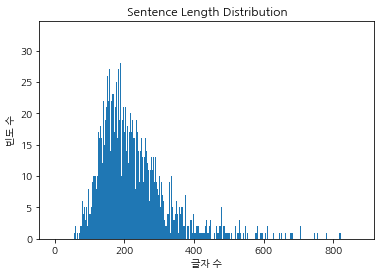

In [15]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus_cov = list(set(train_data.conversation))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus_cov))



# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='NanumGothic')  # 리눅스의 경우 나눔고딕 폰트를 사용하도록 변경해주세요.

# 그래프에서 마이너스 기호가 표시되도록 설정
plt.rc('axes', unicode_minus=False)



for sen in cleaned_corpus_cov:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus_cov))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus_cov:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.xlabel(xlabel='글자 수')
plt.ylabel(ylabel='빈도 수')
plt.show()

최대길이: 874
최소길이: 41
평균길이: 226.57088607594937


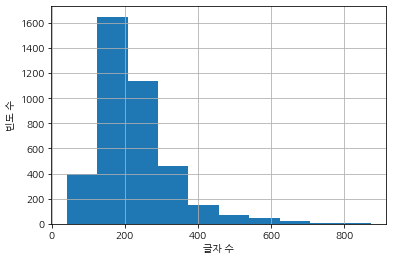

In [16]:
# 중복제거 
ax = train_data.conversation.str.len().hist()

max_length = train_data.conversation.str.len().max()
min_length = train_data.conversation.str.len().min()
mean_length = train_data.conversation.str.len().mean()

ax.set_xlabel(xlabel='글자 수')
ax.set_ylabel(ylabel='빈도 수')

print("최대길이:", max_length)
print("최소길이:", min_length)
print("평균길이:", mean_length)

중복을 제거하나 안하나 별 차이가 없다. 그냥 데이터 정제나 해야겠다. 

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

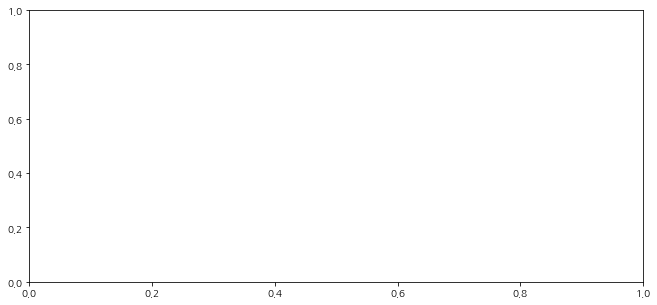

In [22]:
# 라벨 데이터 분포 확인
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=train_data)
plt.show()

In [ ]:
len(cleaned_corpus_cov)

In [ ]:
cleaned_400 = cleaned_corpus_cov[:400]
cleaned_400

### Step2. 데이터 정제

In [ ]:
vocab_size = 500
max_len = 

In [ ]:
def preprocess_sentence(sentence, s_token=True, e_token=True):
    sentence = re.sub(r"([?.!,])", r" \1 ", str(sentence))
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,가-힣ㄱ-ㅎㅏ-ㅣ0-9]+", " ", sentence)
    sentence = sentence.strip()
    
    return sentence

In [ ]:
pre_data = list(map(preprocess_sentence, cleaned_corpus_cov))
print(pre_data)
print(len(pre_data))
print(type(pre_data))

In [ ]:
pre_400 = list(map(preprocess_sentence, cleaned_400))
print(pre_400)
print(len(pre_400))
print(type(pre_400))

In [ ]:
pre_test_data = list(map(preprocess_sentence, test_data.text))
print(pre_test_data)
print(len(pre_test_data))
print(type(pre_test_data))

In [ ]:
# # index_word로 바꾸기
# index_to_word = { index+3 : word for word, index in word_index.items() }

# for index, token in enumerate(("<pad>", "<sos>", "<unk>")):

# index_to_word[index] = token

In [ ]:
def tokenize2(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    
    mecab = Mecab()
    corpus = [' '.join(mecab.morphs(sen)) for sen in corpus]
        
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen=500)
    
    return tensor, tokenizer

In [ ]:
conv_tensor, conv_tokenizer = tokenize2(pre_data)
print(f'Converasation Vocab Size: {len(conv_tokenizer.index_word)}')
conv400_tensor, conv400_tokenizer = tokenize2(pre_400)
print(f'Converasation_400 Vocab Size: {len(conv_tokenizer.index_word)}')
test_tensor, test_tokenizer = tokenize2(pre_test_data)
print(f'Text Vocab Size: {len(test_tokenizer.index_word)}')

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(conv400_tensor, test_tensor, test_size=0.2)

len(x_train), len(x_test), len(y_train), len(y_test)

### Step 3: 모델 설계

1. BahdanauAttention 

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

print("슝~")

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True)
        
        self.dropout = tf.keras.layers.Dropout(rate=0.2)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        out = self.dropout(out)
        
        return out

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units, return_sequences=True, return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)
        
        self.dropout = tf.keras.layers.Dropout(rate=0.2)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = self.dropout(out)
        
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [ ]:
# 코드를 실행하세요.
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(conv400_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(test_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

### Step 4: 훈련하기 

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

print("슝~")

In [ ]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']]*bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

print("슝~")

In [ ]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, x_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(x_train[idx:idx+BATCH_SIZE],
                                y_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                test_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm